In [1]:
from torch_geometric.data import Dataset, Data
from torch_geometric.nn import knn_graph
import os.path as osp
import pandas as pd
import numpy as np
import torch
import h5py

In [2]:
class AudioGraphDataset(Dataset):
    def __init__(self, root, path, k_neigh=5, enable=False, transform=None, pre_transform=None, pre_filter=None):
        """
        Initialize the Audio Graph Dataset
        Args:
            root: Root directory for processed files
            path: List containing paths to [csv_file, hdf5_file]
            k_neigh: Number of nearest neighbors for graph construction
            enable: Flag for extended processing mode
            transform: Transform to be applied to the data
            pre_transform: Transform to be applied before processing
            pre_filter: Filter to be applied before processing
        """
        self.csv_path = path[0]
        self.hdf5_path = path[1]
        self.enable = enable
        self.k_neigh = k_neigh
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        # Return the actual filenames without full paths
        return [osp.basename(self.csv_path), osp.basename(self.hdf5_path)]

    @property
    def raw_dir(self) -> str:
        # Return the directory containing the raw files
        return osp.dirname(self.csv_path)

    @property
    def processed_file_names(self):
        # Return list of processed file names based on enable flag
        if not self.enable:
            return [f'data_{i}.pt' for i in range(10)]
        else:
            return [f'data_{i}.pt' for i in range(109)]

    def download(self):
        # No download needed as we're using local files
        pass

    def process(self):
        """
        Process the raw data into graph format
        - Loads features and labels from HDF5
        - Performs cross-validation splits
        - Creates graph structure using kNN
        - Saves processed graphs
        """
        # Load metadata and features using full paths
        self.df = pd.read_csv(self.csv_path)
        self.data = h5py.File(self.hdf5_path, 'r')
        
        # Convert features and labels to torch tensors
        X_tensor = torch.tensor(np.array(self.data['features']))
        Y_tensor = torch.tensor(np.array(self.data['labels']))

        if not self.enable:
            # Standard processing mode - 10 fold cross validation
            self._process_folds(X_tensor, Y_tensor, 0, 10)
        else:
            # Extended processing mode - varying k neighbors
            for k in range(5, 115, 10):
                start_idx = (k - 5) // 10 * 10
                self._process_folds(X_tensor, Y_tensor, start_idx, 10, k)

    def _process_folds(self, X_tensor, Y_tensor, start_idx, num_folds, k_neighbors=None):
        """
        Process data for multiple cross-validation folds
        """
        test_idx = 1
        val_idx = 2
        k = k_neighbors if k_neighbors is not None else self.k_neigh

        for j in range(start_idx, start_idx + num_folds):
            # Get train/test/validation splits
            idx_train, idx_test, idx_val = self._cross_validation_split(
                self.df, test_idx, val_idx)
            
            # Normalize features
            X_tensor_norm = self._normalize_features(X_tensor, idx_train)
            
            # Create graph data object
            data = self._create_graph(X_tensor_norm, Y_tensor, 
                                    idx_train, idx_test, idx_val, k)
            
            # Save processed data
            torch.save(data, osp.join(self.processed_dir, f'data_{j}.pt'))
            
            # Update indices for next fold
            test_idx = (test_idx + 1) % 11
            val_idx = (val_idx + 1) % 11
            if val_idx == 0:
                val_idx = 1

    def _normalize_features(self, X_tensor, idx_train):
        """
        Normalize features using min-max scaling based on training set
        """
        mini = X_tensor[idx_train].min()
        maxi = X_tensor[idx_train].max()
        return (X_tensor - mini) / (maxi - mini)

    def _cross_validation_split(self, df, idx_test, idx_val):
        """
        Create train/test/validation splits using fold information
        """
        df = df.reset_index(drop=True)
        df_train = df.copy()
        
        # Get test indices and remove from training
        idx_test_mask = df.index[df.fold == idx_test]
        df_train.drop(idx_test_mask, inplace=True)
        
        # Get validation indices and remove from training
        idx_val_mask = df.index[df.fold == idx_val]
        df_train.drop(idx_val_mask, inplace=True)
        
        # Remaining indices are training set
        idx_train_mask = df_train.index
        
        return idx_train_mask, idx_test_mask, idx_val_mask

    def _create_graph(self, X_tensor, Y_tensor, idx_train, idx_test, idx_val, k):
        """
        Create a graph using feature tensors and kNN
        """
        # Convert indices to tensors
        train_mask = torch.tensor(idx_train)
        test_mask = torch.tensor(idx_test)
        val_mask = torch.tensor(idx_val)

        # Create edge connections using kNN
        edge_index = knn_graph(X_tensor, k=k, batch=Y_tensor, loop=False)

        # Create and return the graph data object
        return Data(
            x=X_tensor,
            edge_index=edge_index,
            y=Y_tensor,
            train_mask=train_mask,
            test_mask=test_mask,
            val_mask=val_mask
        )

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        """Load and return a specific graph"""
        return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt')) 

In [3]:
# Example usage
dataset = AudioGraphDataset(
    root='processed_data',
    path=['nepali_music_metadata.csv', 'nepali_features.hdf5'],
    k_neigh=5
)

Processing...
Done!


In [4]:
# Access a specific graph
graph = dataset[0]

/tmp/ipykernel_12990/3004764370.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))


In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import torch
import numpy as np

In [6]:
def visualize_graph_with_edges(data, title="Audio Graph Visualization", color_by='label',
                                layout='spring', fig_size=(12, 8), edge_alpha=0.1, 
                                node_size=100, edge_size=0.5):
    """
    Visualize the audio graph with edges (transparent), different layout options and tunable node/edge sizes.
    
    Args:
        data: PyG Data object containing the graph
        title: Title for the visualization
        color_by: 'label' or 'split' to color nodes by class labels or train/val/test split
        layout: Layout algorithm ('spring', 'circular', 'spectral', 'random')
        fig_size: Size of the figure (width, height)
        edge_alpha: Transparency of the edges (0=invisible, 1=opaque)
        node_size: Size of the nodes
        edge_size: Size (linewidth) of the edges
    """
    # Convert to networkx graph
    G = to_networkx(data, to_undirected=True)
    
    # Get node positions based on layout algorithm
    if layout == 'spring':
        pos = nx.spring_layout(G, k=0.5)
    elif layout == 'circular':
        pos = nx.circular_layout(G)
    elif layout == 'spectral':
         pos = nx.spectral_layout(G)
    elif layout == 'random':
        pos = nx.random_layout(G)
    else:
       raise ValueError("Invalid layout algorithm. Choose from 'spring', 'circular', 'spectral', or 'random'.")
    
    plt.figure(figsize=fig_size)
    
    if color_by == 'label':
        # Color by class labels
        labels = data.y.numpy()
        unique_labels = np.unique(labels)
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
        color_dict = dict(zip(unique_labels, colors))
        node_colors = [color_dict[label] for label in labels]
        
        # Create legend handles
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=color,
                                    label=f'Fold {label}', markersize=10)
                         for label, color in color_dict.items()]
        
    else:  # color_by == 'split'
        # Color by train/val/test split
        colors = []
        for i in range(len(G)):
            if i in data.train_mask:
                colors.append('blue')
            elif i in data.val_mask:
                colors.append('green')
            elif i in data.test_mask:
                colors.append('red')
        node_colors = colors
        
        # Create legend handles
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
                      label='Train', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green',
                      label='Validation', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
                      label='Test', markersize=10)
        ]
    
    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_size, alpha=0.7)
    nx.draw_networkx_edges(G, pos, alpha=edge_alpha, width=edge_size)

    plt.legend(handles=legend_elements)
    plt.title(title)
    plt.show()


def visualize_graph_metrics(data):
    """
    Visualize graph metrics such as degree distribution
    
    Args:
        data: PyG Data object containing the graph
    """
    G = to_networkx(data, to_undirected=True)
    
    # Calculate degree for each node
    degrees = [d for n, d in G.degree()]
    
    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=30, alpha=0.7)
    plt.xlabel('Node Degree')
    plt.ylabel('Count')
    plt.title('Degree Distribution')
    plt.show()
    
    # Print some graph statistics
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(degrees) / len(degrees):.2f}")
    print(f"Graph density: {nx.density(G):.4f}")

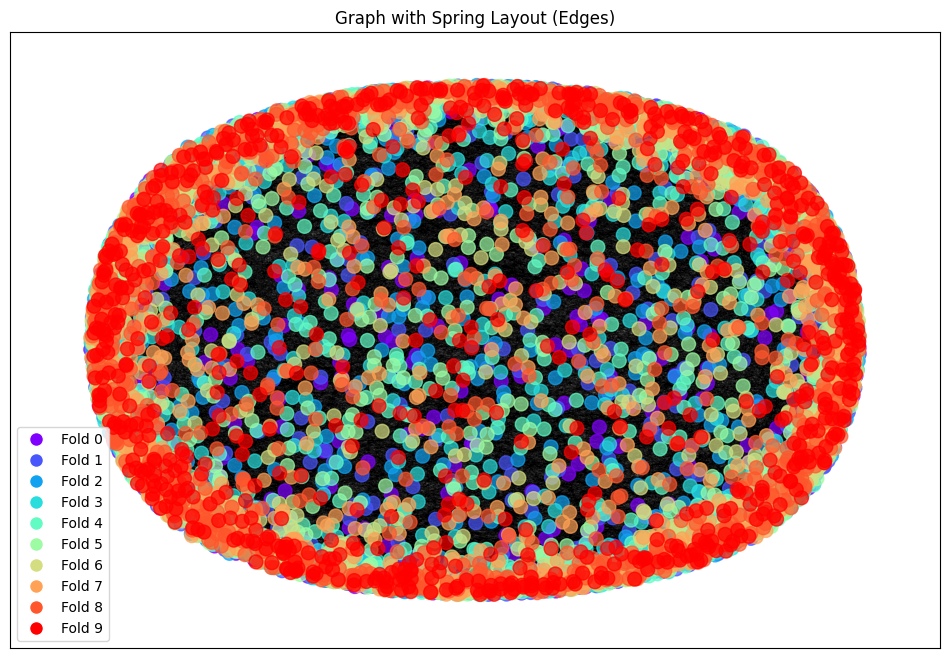

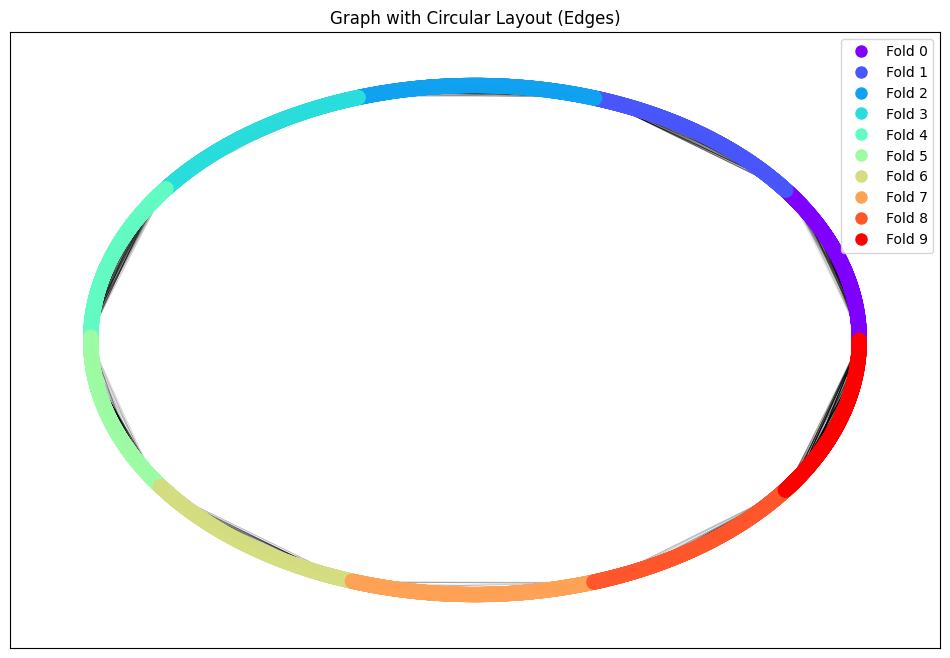

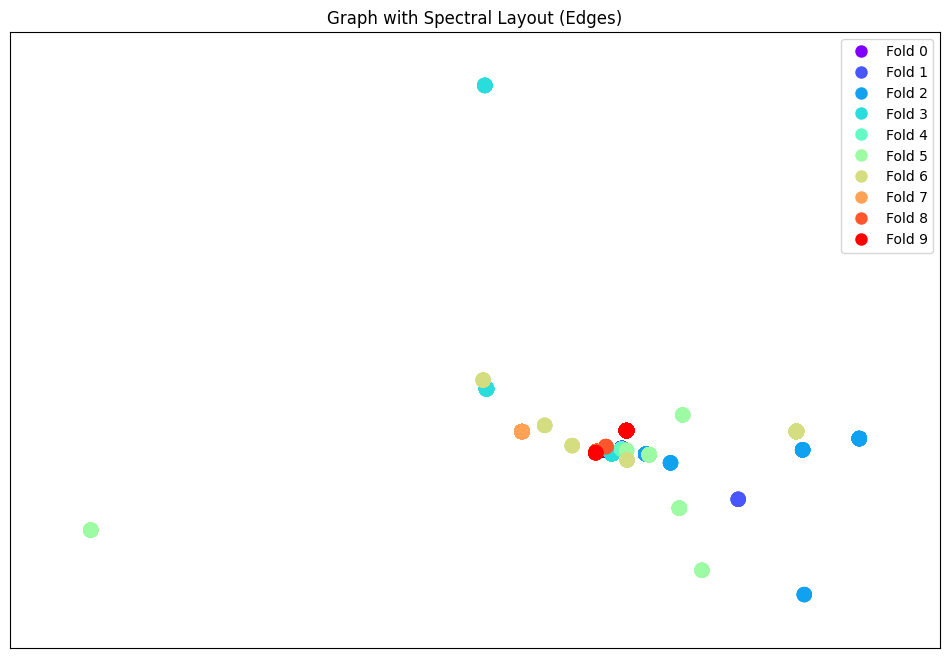

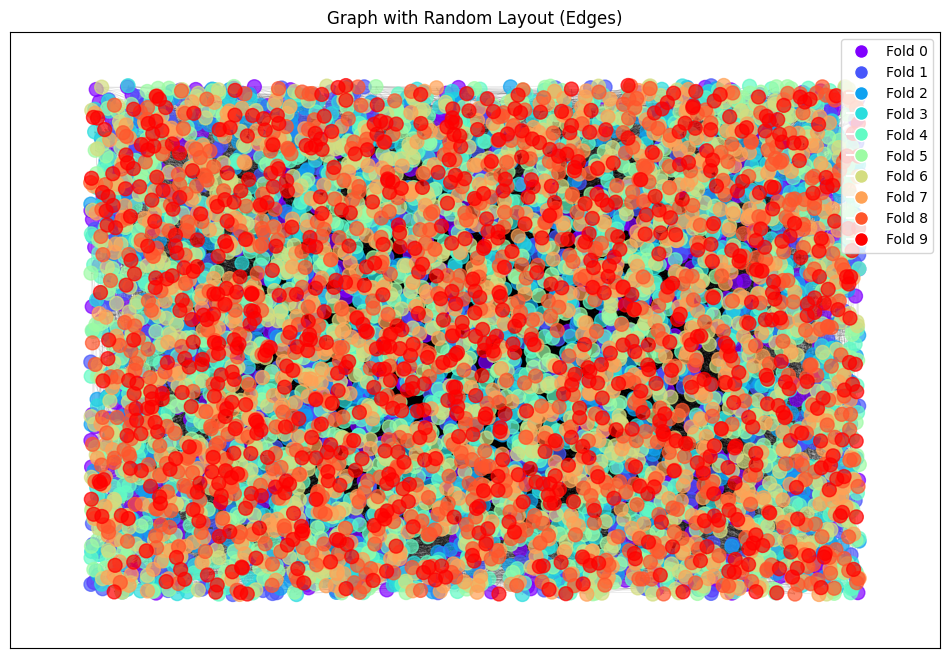

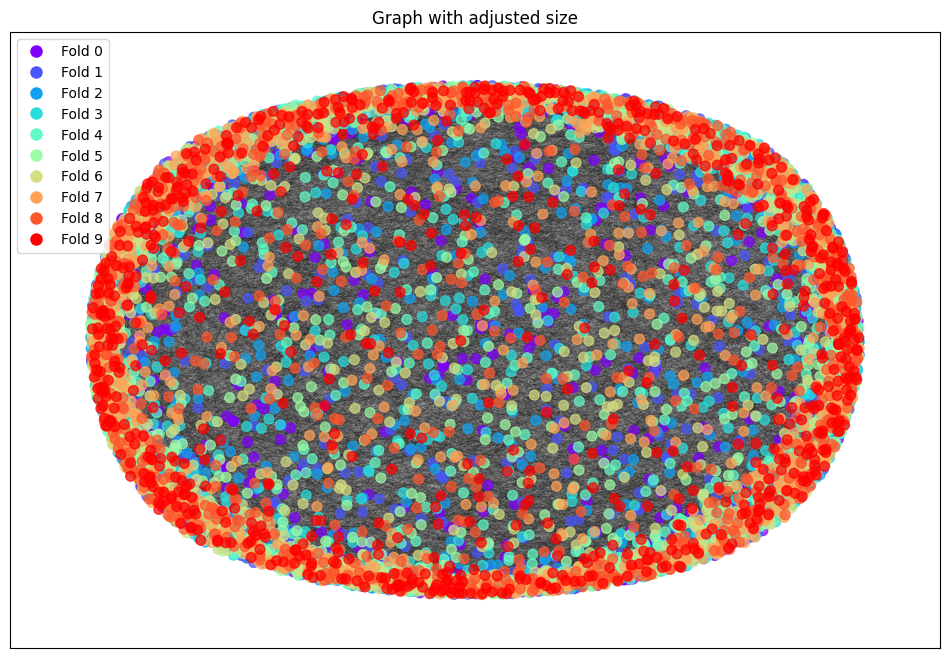

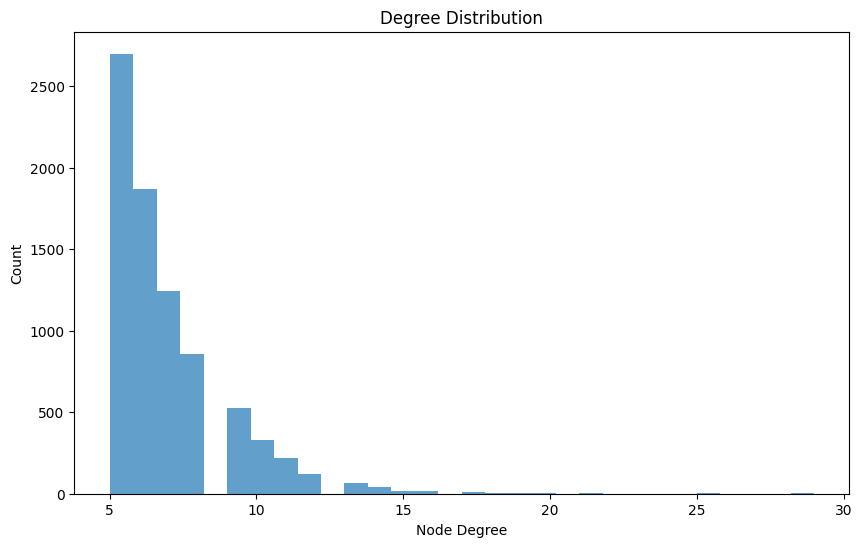

Number of nodes: 8037
Number of edges: 27353
Average degree: 6.81
Graph density: 0.0008


In [7]:
# Assuming you have loaded a PyG Data object named 'data'
# Visualize with edges, spring layout, with low transparency:
visualize_graph_with_edges(graph, title="Graph with Spring Layout (Edges)",
                          color_by='label', layout='spring', edge_alpha=0.1)

# Visualize with edges, circular layout, with low transparency
visualize_graph_with_edges(graph, title="Graph with Circular Layout (Edges)",
                          color_by='label', layout='circular', edge_alpha=0.1)

# Visualize with edges, spectral layout, with low transparency
visualize_graph_with_edges(graph, title="Graph with Spectral Layout (Edges)",
                          color_by='label', layout='spectral', edge_alpha=0.1)

# Visualize with edges, random layout, with low transparency
visualize_graph_with_edges(graph, title="Graph with Random Layout (Edges)",
                          color_by='label', layout='random', edge_alpha=0.1)

visualize_graph_with_edges(graph, title="Graph with adjusted size",
                          color_by='label', layout='spring', edge_alpha=0.1, 
                          node_size=50, edge_size=0.2)


# Visualize graph metrics
visualize_graph_metrics(graph)

## Training 

In [21]:
class GCNAudioClassifier(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.3):
        """
        GCN model for audio classification
        Args:
            num_features: Number of input features (1024 for YaMNet)
            hidden_channels: Number of hidden units
            num_classes: Number of output classes
            dropout: Dropout rate
        """
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)
        self.dropout = dropout
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)

    def forward(self, x, edge_index):
        # First Graph Convolution
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Apply batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second Graph Convolution
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Apply batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Final Graph Convolution
        x = self.conv3(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [22]:
def train_model(model, data, optimizer, epochs=200):
    """
    Train the GCN model with early stopping
    Args:
        model: GCN model instance
        data: PyG Data object containing the graph
        optimizer: PyTorch optimizer
        epochs: Number of training epochs
    Returns:
        lists of training/validation losses and accuracies
    """
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    # Early stopping parameters
    best_val_loss = float('inf')
    patience = 20  # Number of epochs to wait for improvement
    epochs_without_improvement = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        
        # Calculate loss only on training nodes
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            
            # Training metrics
            train_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask]).item()
            train_acc = accuracy_score(data.y[data.train_mask].cpu(), 
                                    out[data.train_mask].argmax(dim=1).cpu())
            
            # Validation metrics
            val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask]).item()
            val_acc = accuracy_score(data.y[data.val_mask].cpu(), 
                                   out[data.val_mask].argmax(dim=1).cpu())
            
        # Append metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1:03d}, '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    return train_losses, val_losses, train_accs, val_accs

In [23]:
def evaluate_model(model, data):
    """
    Evaluate the model on test set
    Args:
        model: Trained GCN model
        data: PyG Data object containing the graph
    Returns:
        dict containing various metrics
    """
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[data.test_mask].argmax(dim=1).cpu()
        true = data.y[data.test_mask].cpu()
        
        # Calculate metrics
        accuracy = accuracy_score(true, pred)
        precision, recall, f1, _ = precision_recall_fscore_support(true, pred, average='weighted')
        
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [24]:
from collections import defaultdict

def train_k_fold(dataset, hidden_channels=32, dropout=0.3, epochs=200, lr=0.01):
    """
    Perform k-fold cross validation training with L2 regularization and learning rate scheduling
    Args:
        dataset: AudioGraphDataset instance
        hidden_channels: Number of hidden units in GCN
        dropout: Dropout rate
        epochs: Number of epochs per fold
        lr: Learning rate
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Store metrics for each fold
    fold_metrics = defaultdict(list)
    all_train_losses = []
    all_val_losses = []
    all_train_accs = []
    all_val_accs = []
    
    print(f"Training on {len(dataset)} folds...")
    
    for fold in range(len(dataset)):
        print(f"\nTraining Fold {fold + 1}/{len(dataset)}")
        
        # Get graph data for current fold
        data = dataset[fold].to(device)
        
        # # Initialize model with YaMNet dimensionality
        model = GCNAudioClassifier(
            num_features=1024,  # Changed from 128 to 1024
            hidden_channels=hidden_channels,
            num_classes=10,    
            dropout=dropout
        ).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)  # L2 regularization
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)  # LR scheduling
        
        # Train on this fold
        train_losses, val_losses, train_accs, val_accs = train_model(
            model=model,
            data=data,
            optimizer=optimizer,
            epochs=epochs
        )
        
        # Store training curves
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_train_accs.append(train_accs)
        all_val_accs.append(val_accs)
        
        # Evaluate on test set
        test_metrics = evaluate_model(model, data)
        for metric, value in test_metrics.items():
            fold_metrics[metric].append(value)
        
        print(f"Fold {fold + 1} Test Metrics:")
        for metric, value in test_metrics.items():
            print(f"{metric.capitalize()}: {value:.4f}")
    
    # Calculate average metrics across folds
    print("\nOverall Cross-Validation Results:")
    for metric, values in fold_metrics.items():
        mean_value = np.mean(values)
        std_value = np.std(values)
        print(f"{metric.capitalize()}: {mean_value:.4f} ± {std_value:.4f}")
    
    return fold_metrics, (all_train_losses, all_val_losses, all_train_accs, all_val_accs) 

In [25]:
def plot_k_fold_curves(all_train_losses, all_val_losses, all_train_accs, all_val_accs):
    """Plot average training curves across all folds with standard deviation"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Find the maximum length across all folds
    max_length = max(len(fold) for fold in all_train_losses)
    
    # Pad shorter folds with NaN values to make all folds the same length
    def pad_fold(fold, max_length):
        return np.pad(fold, (0, max_length - len(fold)), mode='constant', constant_values=np.nan)
    
    all_train_losses = [pad_fold(fold, max_length) for fold in all_train_losses]
    all_val_losses = [pad_fold(fold, max_length) for fold in all_val_losses]
    all_train_accs = [pad_fold(fold, max_length) for fold in all_train_accs]
    all_val_accs = [pad_fold(fold, max_length) for fold in all_val_accs]
    
    # Convert to numpy arrays
    all_train_losses = np.array(all_train_losses)
    all_val_losses = np.array(all_val_losses)
    all_train_accs = np.array(all_train_accs)
    all_val_accs = np.array(all_val_accs)
    
    # Calculate mean and std for losses
    train_losses_mean = np.nanmean(all_train_losses, axis=0)  # Ignore NaNs
    train_losses_std = np.nanstd(all_train_losses, axis=0)    # Ignore NaNs
    val_losses_mean = np.nanmean(all_val_losses, axis=0)      # Ignore NaNs
    val_losses_std = np.nanstd(all_val_losses, axis=0)        # Ignore NaNs
    
    # Calculate mean and std for accuracies
    train_accs_mean = np.nanmean(all_train_accs, axis=0)      # Ignore NaNs
    train_accs_std = np.nanstd(all_train_accs, axis=0)        # Ignore NaNs
    val_accs_mean = np.nanmean(all_val_accs, axis=0)          # Ignore NaNs
    val_accs_std = np.nanstd(all_val_accs, axis=0)            # Ignore NaNs
    
    # Plot losses
    epochs = range(1, len(train_losses_mean) + 1)
    ax1.plot(epochs, train_losses_mean, label='Train Loss')
    ax1.fill_between(epochs, train_losses_mean - train_losses_std, 
                    train_losses_mean + train_losses_std, alpha=0.2)
    ax1.plot(epochs, val_losses_mean, label='Validation Loss')
    ax1.fill_between(epochs, val_losses_mean - val_losses_std,
                    val_losses_mean + val_losses_std, alpha=0.2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Average Training and Validation Loss')
    
    # Plot accuracies
    ax2.plot(epochs, train_accs_mean, label='Train Accuracy')
    ax2.fill_between(epochs, train_accs_mean - train_accs_std,
                    train_accs_mean + train_accs_std, alpha=0.2)
    ax2.plot(epochs, val_accs_mean, label='Validation Accuracy')
    ax2.fill_between(epochs, val_accs_mean - val_accs_std,
                    val_accs_mean + val_accs_std, alpha=0.2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title('Average Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.show()

Training on 10 folds...

Training Fold 1/10
Epoch 010, Train Loss: 2.0354, Train Acc: 0.5163, Val Loss: 2.0387, Val Acc: 0.5124


/tmp/ipykernel_12990/3004764370.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))


Epoch 020, Train Loss: 1.4524, Train Acc: 0.6706, Val Loss: 1.4756, Val Acc: 0.6530
Epoch 030, Train Loss: 0.8674, Train Acc: 0.7759, Val Loss: 0.9044, Val Acc: 0.7438
Epoch 040, Train Loss: 0.5996, Train Acc: 0.8354, Val Loss: 0.6294, Val Acc: 0.8122
Epoch 050, Train Loss: 0.5159, Train Acc: 0.8543, Val Loss: 0.5519, Val Acc: 0.8507
Epoch 060, Train Loss: 0.5108, Train Acc: 0.8620, Val Loss: 0.5339, Val Acc: 0.8470
Epoch 070, Train Loss: 0.2730, Train Acc: 0.9250, Val Loss: 0.2960, Val Acc: 0.9080
Epoch 080, Train Loss: 0.2533, Train Acc: 0.9228, Val Loss: 0.2757, Val Acc: 0.9129
Epoch 090, Train Loss: 0.2399, Train Acc: 0.9174, Val Loss: 0.2521, Val Acc: 0.9092
Epoch 100, Train Loss: 0.1818, Train Acc: 0.9546, Val Loss: 0.1982, Val Acc: 0.9502
Epoch 110, Train Loss: 0.1317, Train Acc: 0.9620, Val Loss: 0.1358, Val Acc: 0.9590
Epoch 120, Train Loss: 0.2070, Train Acc: 0.9350, Val Loss: 0.2135, Val Acc: 0.9254
Epoch 130, Train Loss: 0.1475, Train Acc: 0.9477, Val Loss: 0.1713, Val Acc:

/tmp/ipykernel_12990/3004764370.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/minicond

Epoch 030, Train Loss: 0.7721, Train Acc: 0.8015, Val Loss: 0.7760, Val Acc: 0.8060
Epoch 040, Train Loss: 0.4801, Train Acc: 0.8684, Val Loss: 0.5005, Val Acc: 0.8644
Epoch 050, Train Loss: 0.3681, Train Acc: 0.9017, Val Loss: 0.4349, Val Acc: 0.8769
Epoch 060, Train Loss: 0.3143, Train Acc: 0.8947, Val Loss: 0.3486, Val Acc: 0.8881
Epoch 070, Train Loss: 0.2257, Train Acc: 0.9281, Val Loss: 0.2411, Val Acc: 0.9303
Epoch 080, Train Loss: 0.2093, Train Acc: 0.9421, Val Loss: 0.2413, Val Acc: 0.9279
Epoch 090, Train Loss: 0.1266, Train Acc: 0.9622, Val Loss: 0.1518, Val Acc: 0.9552
Epoch 100, Train Loss: 0.1255, Train Acc: 0.9697, Val Loss: 0.1462, Val Acc: 0.9689
Epoch 110, Train Loss: 0.2625, Train Acc: 0.9308, Val Loss: 0.3130, Val Acc: 0.9142
Epoch 120, Train Loss: 0.2230, Train Acc: 0.9322, Val Loss: 0.2590, Val Acc: 0.9216
Early stopping at epoch 126
Fold 2 Test Metrics:
Accuracy: 0.9266
Precision: 0.9365
Recall: 0.9266
F1: 0.9272

Training Fold 3/10
Epoch 010, Train Loss: 2.0678,

/tmp/ipykernel_12990/3004764370.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/minicond

Epoch 040, Train Loss: 0.6087, Train Acc: 0.8399, Val Loss: 0.6222, Val Acc: 0.8296
Epoch 050, Train Loss: 0.4281, Train Acc: 0.8748, Val Loss: 0.4586, Val Acc: 0.8669
Epoch 060, Train Loss: 0.3099, Train Acc: 0.9126, Val Loss: 0.3364, Val Acc: 0.9042
Epoch 070, Train Loss: 0.2947, Train Acc: 0.9028, Val Loss: 0.3379, Val Acc: 0.8905
Epoch 080, Train Loss: 0.3448, Train Acc: 0.8818, Val Loss: 0.3431, Val Acc: 0.8806
Early stopping at epoch 86
Fold 3 Test Metrics:
Accuracy: 0.8483
Precision: 0.8892
Recall: 0.8483
F1: 0.8556

Training Fold 4/10
Epoch 010, Train Loss: 1.8810, Train Acc: 0.5760, Val Loss: 1.8908, Val Acc: 0.5460
Epoch 020, Train Loss: 1.2273, Train Acc: 0.6640, Val Loss: 1.2313, Val Acc: 0.6629
Epoch 030, Train Loss: 0.7805, Train Acc: 0.7920, Val Loss: 0.7857, Val Acc: 0.7923
Epoch 040, Train Loss: 0.4883, Train Acc: 0.8698, Val Loss: 0.5129, Val Acc: 0.8595


/tmp/ipykernel_12990/3004764370.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/minicond

Epoch 050, Train Loss: 0.3757, Train Acc: 0.8854, Val Loss: 0.4117, Val Acc: 0.8706
Epoch 060, Train Loss: 0.3006, Train Acc: 0.9012, Val Loss: 0.3150, Val Acc: 0.8856
Epoch 070, Train Loss: 0.2345, Train Acc: 0.9289, Val Loss: 0.2584, Val Acc: 0.9080
Epoch 080, Train Loss: 0.1957, Train Acc: 0.9319, Val Loss: 0.2133, Val Acc: 0.9216
Epoch 090, Train Loss: 0.2495, Train Acc: 0.9236, Val Loss: 0.2957, Val Acc: 0.9030
Epoch 100, Train Loss: 0.2089, Train Acc: 0.9487, Val Loss: 0.2299, Val Acc: 0.9453
Early stopping at epoch 101
Fold 4 Test Metrics:
Accuracy: 0.9515
Precision: 0.9595
Recall: 0.9515
F1: 0.9532

Training Fold 5/10
Epoch 010, Train Loss: 2.0344, Train Acc: 0.5279, Val Loss: 2.0447, Val Acc: 0.4851
Epoch 020, Train Loss: 1.4004, Train Acc: 0.6205, Val Loss: 1.4147, Val Acc: 0.6244
Epoch 030, Train Loss: 0.8747, Train Acc: 0.7583, Val Loss: 0.9007, Val Acc: 0.7612
Epoch 040, Train Loss: 0.5164, Train Acc: 0.8599, Val Loss: 0.5337, Val Acc: 0.8619


/tmp/ipykernel_12990/3004764370.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/minicond

Epoch 050, Train Loss: 0.3982, Train Acc: 0.8922, Val Loss: 0.3972, Val Acc: 0.8955
Epoch 060, Train Loss: 0.2627, Train Acc: 0.9233, Val Loss: 0.2787, Val Acc: 0.9266
Epoch 070, Train Loss: 0.2661, Train Acc: 0.9205, Val Loss: 0.2867, Val Acc: 0.9030
Epoch 080, Train Loss: 0.2281, Train Acc: 0.9208, Val Loss: 0.2223, Val Acc: 0.9316
Epoch 090, Train Loss: 0.2018, Train Acc: 0.9370, Val Loss: 0.2071, Val Acc: 0.9391
Epoch 100, Train Loss: 0.1491, Train Acc: 0.9614, Val Loss: 0.1494, Val Acc: 0.9639
Epoch 110, Train Loss: 0.1134, Train Acc: 0.9695, Val Loss: 0.1441, Val Acc: 0.9590
Epoch 120, Train Loss: 0.1530, Train Acc: 0.9549, Val Loss: 0.1310, Val Acc: 0.9540
Epoch 130, Train Loss: 0.2298, Train Acc: 0.9214, Val Loss: 0.2521, Val Acc: 0.9142
Early stopping at epoch 138
Fold 5 Test Metrics:
Accuracy: 0.9677
Precision: 0.9709
Recall: 0.9677
F1: 0.9679

Training Fold 6/10


/tmp/ipykernel_12990/3004764370.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/minicond

Epoch 010, Train Loss: 2.1263, Train Acc: 0.4634, Val Loss: 2.0999, Val Acc: 0.4789
Epoch 020, Train Loss: 1.4098, Train Acc: 0.6430, Val Loss: 1.4012, Val Acc: 0.6604
Epoch 030, Train Loss: 0.9012, Train Acc: 0.7555, Val Loss: 0.9254, Val Acc: 0.7649
Epoch 040, Train Loss: 0.6022, Train Acc: 0.8247, Val Loss: 0.6588, Val Acc: 0.8172
Epoch 050, Train Loss: 0.3909, Train Acc: 0.8964, Val Loss: 0.4200, Val Acc: 0.8744
Epoch 060, Train Loss: 0.4283, Train Acc: 0.8490, Val Loss: 0.4435, Val Acc: 0.8458
Epoch 070, Train Loss: 0.3162, Train Acc: 0.8970, Val Loss: 0.3513, Val Acc: 0.8806
Epoch 080, Train Loss: 0.2510, Train Acc: 0.9155, Val Loss: 0.2641, Val Acc: 0.9080
Epoch 090, Train Loss: 0.1689, Train Acc: 0.9529, Val Loss: 0.1841, Val Acc: 0.9440
Epoch 100, Train Loss: 0.2095, Train Acc: 0.9451, Val Loss: 0.2148, Val Acc: 0.9303
Epoch 110, Train Loss: 0.1684, Train Acc: 0.9603, Val Loss: 0.1804, Val Acc: 0.9552
Epoch 120, Train Loss: 0.1363, Train Acc: 0.9578, Val Loss: 0.1500, Val Acc:

/tmp/ipykernel_12990/3004764370.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/minicond

Epoch 020, Train Loss: 1.4508, Train Acc: 0.6238, Val Loss: 1.4402, Val Acc: 0.6127
Epoch 030, Train Loss: 0.9205, Train Acc: 0.7742, Val Loss: 0.9277, Val Acc: 0.7721
Epoch 040, Train Loss: 0.6058, Train Acc: 0.8213, Val Loss: 0.6031, Val Acc: 0.8032
Epoch 050, Train Loss: 0.4783, Train Acc: 0.8456, Val Loss: 0.4776, Val Acc: 0.8331
Epoch 060, Train Loss: 0.3160, Train Acc: 0.9003, Val Loss: 0.3234, Val Acc: 0.8867
Epoch 070, Train Loss: 0.2817, Train Acc: 0.9070, Val Loss: 0.3019, Val Acc: 0.8892
Epoch 080, Train Loss: 0.1806, Train Acc: 0.9485, Val Loss: 0.1954, Val Acc: 0.9427
Epoch 090, Train Loss: 0.1920, Train Acc: 0.9527, Val Loss: 0.1887, Val Acc: 0.9577
Epoch 100, Train Loss: 0.2311, Train Acc: 0.9421, Val Loss: 0.2471, Val Acc: 0.9390
Epoch 110, Train Loss: 0.1758, Train Acc: 0.9449, Val Loss: 0.1719, Val Acc: 0.9514
Early stopping at epoch 111
Fold 7 Test Metrics:
Accuracy: 0.9328
Precision: 0.9412
Recall: 0.9328
F1: 0.9326

Training Fold 8/10


/tmp/ipykernel_12990/3004764370.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/minicond

Epoch 010, Train Loss: 1.9433, Train Acc: 0.4926, Val Loss: 1.9342, Val Acc: 0.5068
Epoch 020, Train Loss: 1.2861, Train Acc: 0.6609, Val Loss: 1.2587, Val Acc: 0.6849
Epoch 030, Train Loss: 0.8732, Train Acc: 0.7596, Val Loss: 0.8473, Val Acc: 0.7621
Epoch 040, Train Loss: 0.6027, Train Acc: 0.8192, Val Loss: 0.5566, Val Acc: 0.8381
Epoch 050, Train Loss: 0.4444, Train Acc: 0.8671, Val Loss: 0.4323, Val Acc: 0.8543
Epoch 060, Train Loss: 0.3008, Train Acc: 0.9167, Val Loss: 0.2958, Val Acc: 0.9091
Epoch 070, Train Loss: 0.2548, Train Acc: 0.9246, Val Loss: 0.2357, Val Acc: 0.9290
Epoch 080, Train Loss: 0.2167, Train Acc: 0.9417, Val Loss: 0.2052, Val Acc: 0.9390
Epoch 090, Train Loss: 0.1277, Train Acc: 0.9683, Val Loss: 0.1274, Val Acc: 0.9689
Epoch 100, Train Loss: 0.2726, Train Acc: 0.9210, Val Loss: 0.2625, Val Acc: 0.9215
Early stopping at epoch 110
Fold 8 Test Metrics:
Accuracy: 0.9639
Precision: 0.9663
Recall: 0.9639
F1: 0.9636

Training Fold 9/10
Epoch 010, Train Loss: 1.9788,

/tmp/ipykernel_12990/3004764370.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/minicond

Epoch 040, Train Loss: 0.5395, Train Acc: 0.8501, Val Loss: 0.5775, Val Acc: 0.8406
Epoch 050, Train Loss: 0.3968, Train Acc: 0.8793, Val Loss: 0.4311, Val Acc: 0.8717
Epoch 060, Train Loss: 0.2915, Train Acc: 0.9073, Val Loss: 0.3077, Val Acc: 0.9054
Epoch 070, Train Loss: 0.2851, Train Acc: 0.9025, Val Loss: 0.3156, Val Acc: 0.8941
Epoch 080, Train Loss: 0.1806, Train Acc: 0.9504, Val Loss: 0.1982, Val Acc: 0.9427
Epoch 090, Train Loss: 0.1530, Train Acc: 0.9538, Val Loss: 0.1778, Val Acc: 0.9452
Epoch 100, Train Loss: 0.1793, Train Acc: 0.9425, Val Loss: 0.1801, Val Acc: 0.9352
Epoch 110, Train Loss: 0.2596, Train Acc: 0.9317, Val Loss: 0.2852, Val Acc: 0.9253
Early stopping at epoch 115
Fold 9 Test Metrics:
Accuracy: 0.8892
Precision: 0.9042
Recall: 0.8892
F1: 0.8896

Training Fold 10/10
Epoch 010, Train Loss: 2.0202, Train Acc: 0.5148, Val Loss: 1.9985, Val Acc: 0.5249


/tmp/ipykernel_12990/3004764370.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/minicond

Epoch 020, Train Loss: 1.3640, Train Acc: 0.6613, Val Loss: 1.3140, Val Acc: 0.6679
Epoch 030, Train Loss: 0.8679, Train Acc: 0.7362, Val Loss: 0.8283, Val Acc: 0.7537
Epoch 040, Train Loss: 0.5567, Train Acc: 0.8320, Val Loss: 0.5260, Val Acc: 0.8532
Epoch 050, Train Loss: 0.3854, Train Acc: 0.9011, Val Loss: 0.3840, Val Acc: 0.8993
Epoch 060, Train Loss: 0.3090, Train Acc: 0.9031, Val Loss: 0.3071, Val Acc: 0.8881
Epoch 070, Train Loss: 0.3113, Train Acc: 0.9143, Val Loss: 0.2973, Val Acc: 0.9055
Epoch 080, Train Loss: 0.1526, Train Acc: 0.9652, Val Loss: 0.1510, Val Acc: 0.9527
Epoch 090, Train Loss: 0.2357, Train Acc: 0.9253, Val Loss: 0.2406, Val Acc: 0.9216
Epoch 100, Train Loss: 0.1094, Train Acc: 0.9774, Val Loss: 0.1190, Val Acc: 0.9677
Epoch 110, Train Loss: 0.1292, Train Acc: 0.9692, Val Loss: 0.1394, Val Acc: 0.9652
Epoch 120, Train Loss: 0.1169, Train Acc: 0.9720, Val Loss: 0.1281, Val Acc: 0.9677
Epoch 130, Train Loss: 0.2560, Train Acc: 0.9311, Val Loss: 0.2331, Val Acc:

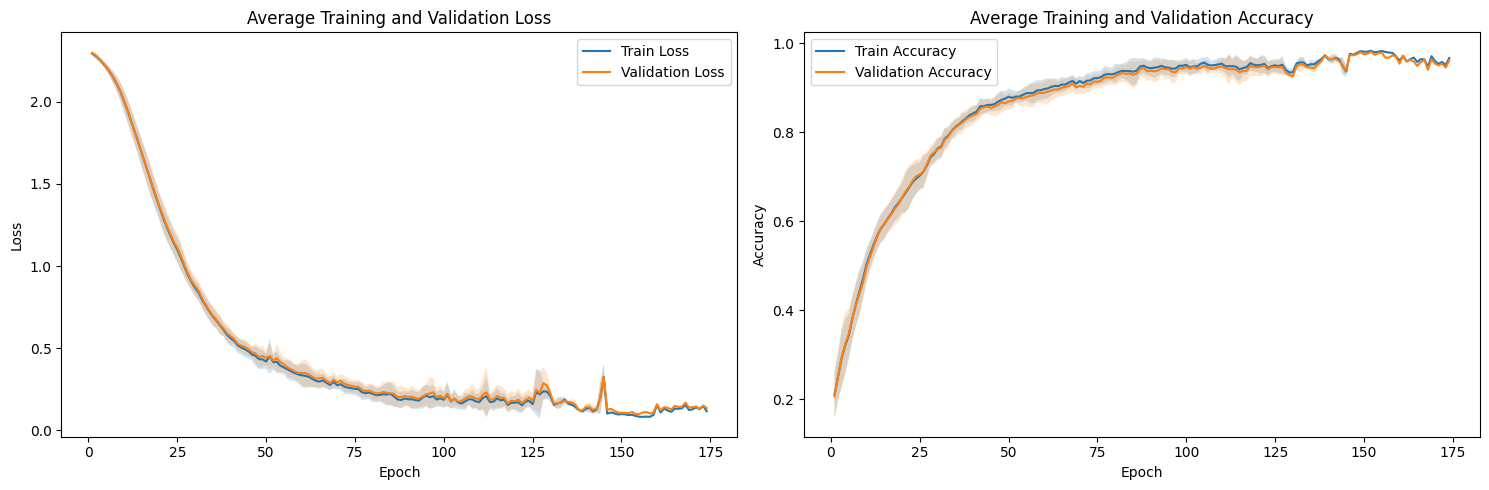

In [26]:
# Use your existing dataset
fold_metrics, curves = train_k_fold(
    dataset=dataset,
    hidden_channels=32,  # Reduced hidden channels
    dropout=0.3,         # Adjusted dropout
    epochs=200,
    lr=0.01
)

# Unpack curves
all_train_losses, all_val_losses, all_train_accs, all_val_accs = curves

# Plot average learning curves across folds
plot_k_fold_curves(all_train_losses, all_val_losses, all_train_accs, all_val_accs)